## This notebook is dedicated to the exploration of the Lyrics dataset


In [102]:
import pandas as pd


In [103]:
n_rows = 100000
lyrics = pd.read_csv('../song_lyrics.csv', nrows=n_rows)
# lyrics[:10, 1:]

In [104]:
#lyrics.iloc[:10, 2:8]
# print(lyrics.iat[9,6])

In [105]:
lyrics.iloc[:10 ]

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en
5,Lollipop Remix,rap,Lil Wayne,2008,580832,"{""Kanye West"",""Static Major""}",[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...,7,en,en,en
6,Im Not You,rap,Clipse,2002,28645,"{Jadakiss,""Styles P"",""Roscoe P. Coldchain""}","[Intro: Pusha T]\nNo, no, no!\nI told you, I l...",8,en,en,en
7,Family Ties,rap,Cam'ron,2004,41960,"{""Cam\\'ron"",""Lady Wray""}","[Verse 1: Cam'ron]\nKilla, Dipset\nMan I spit ...",9,en,en,en
8,Rockin and Rollin,rap,Cam'ron,1998,6399,"{""Cam\\'ron""}",[Verse 1]\nAy yo you wonder who I are\nI guzzl...,10,en,en,en
9,Lord You Know,rap,Cam'ron,2004,11882,"{""Cam\\'ron"",""Juelz Santana"",Jaheim}","[Chorus: Jaheim]\nNow Lord you know, just how ...",11,en,en,en


## Remove brackets
Here we remove the brackets from the lyrics, that they can be used by the classifiers


In [106]:
import re
def preprocess(song):
    output_text = re.sub(r'\[\s*.*?\s*\]\n', '', song)
    return output_text

In [107]:
# Retrieve the content of the cell
import string
cell_content = lyrics.iat[5000,6]  # Replace with the appropriate row and column labels
# print(str(cell_content))
# Specify the file path and name for the text file
file_path = '../files/lyrics.txt'

# Write the cell content to the text file
with open(file_path, 'w') as file:
    lines = str(cell_content).splitlines()
    for line in lines:
        if line.strip():  # Check if the line is non-blank
            # print(line)
            last_two_words = re.findall(r'\b(\w+\W*\w+)\W*$', line)[-1]
            last_two_words = re.sub(r'\d', '', last_two_words)  # Remove numbers
            last_two_words = last_two_words.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
            file.write(last_two_words + '\n')

Here we remove the lyrics of the other languages that are not english, we drop each row which contains such
and we reindex the table afterwards

In [108]:

for i, row in lyrics.iterrows():
    if row['language'] != 'en':
        lyrics.drop(i, inplace=True)
        # print('Hey it is not an english lyrics!')
    else:
        cleaned = preprocess(row['lyrics'])
        lyrics.at[i, 'lyrics'] = cleaned


lyrics.reset_index(drop=True, inplace=True)
# lyrics.iloc[:10]

In [109]:
print(lyrics.shape)

(90138, 11)


## Rhyme extraction
What could be the desired marked formats?
1. Most frequent scheme - ABAB, ABBA (underfitting)
2. The exact words that are being rhymed?
3. The whole rhyming scheme of the song - ABABCDDC-FFFF-ABABCDCD-FFFF-FFFF (overfitting)
4. Multisyllable rhymes - (AB)(AB)(CB)(CB)

In [110]:
# Specify the file path and name
file_path = '../cmudict.dict'

# Create an empty dictionary to store the word-phoneme mappings
word_phoneme_dict = {}

encodings = ['utf-8', 'latin-1', 'utf-16', 'cp1252']
for encoding in encodings:
    try:
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if line:
                    #print(line)
                    split = line.split()
                    word_phoneme_dict[split[0]] = ' '.join(split[1:])
            # break
    except UnicodeDecodeError:
        print('Error')

# Print the dictionary
#print(word_phoneme_dict)

In [111]:
print(word_phoneme_dict.get("ain't"))
print(len(word_phoneme_dict))
# print(word_phoneme_dict)

EY1 N T
135167


In [112]:
import psutil

# Get the current available memory in bytes
available_memory = psutil.virtual_memory().available

# Convert bytes to human-readable format
available_memory_gb = available_memory / (1024 ** 3)  # Convert bytes to gigabytes

# Print the available memory
print(f"Available Memory: {available_memory_gb:.2f} GB")


Available Memory: 5.12 GB


## Idea
We take each row, take the lyrics from it, split the lyrics by whitespace, remove the special characters, maybe remove some stuff that is in the round brackets (aka low voice stuff), then we take only the last two words in each line, and we annotate them with corresponding phonemes

In [113]:
def clean_for_rhymes(lyric):
    lyric = re.sub(r'[^A-Za-z0-9\s]', '', lyric) # remove special chars
    lyric = lyric.lower()
    lyric = lyric.split('\n') # split by new lines
    lyric = list(filter(lambda line: line != '', lyric)) # delete an empty line
    for i, line in enumerate(lyric):
        line = line.split()
        if len(line) >= 2:
            lyric[i] = line[-2:] # take the last two words of each line
        else:
            lyric[i] = line

    return lyric


In [114]:
# create a new column in the dataset and apply the cleaning function to it
lyrics['end words'] = lyrics['lyrics'].apply(clean_for_rhymes)

In [115]:
# lyrics['end words'][1000]
for i in range(lyrics.shape[1]):
    print(lyrics['end words'][i])


[['cam', 'cam'], ['killa', 'cam'], ['cam', 'cam'], ['cam', 'cam'], ['killa', 'cam'], ['killa', 'killa'], ['bases', 'loaded'], ['cam', 'uhhuh'], ['on', 'third'], ['at', 'bat'], ['killa', 'cam'], ['the', 'world'], ['cam', 'cam'], ['killa', 'cam'], ['cam', 'hahahaha'], ['cam', 'cam'], ['killa', 'cam'], ['shit', 'clap'], ['cam', 'cam'], ['killa', 'cam'], ['cam', 'cam'], ['cam', 'cam'], ['killa', 'killa'], ['cam', 'killa'], ['what', 'up'], ['since', 'kumbaya'], ['my', 'lord'], ['on', 'board'], ['tutor', 'me'], ['to', 'me'], ['or', 'dime'], ['hammer', 'time'], ['on', 'nines'], ['camll', 'shine'], ['red', 'red'], ['em', 'lemonheads'], ['like', 'winnipeg'], ['with', 'fred'], ['on', 'scrappy'], ['at', 'me'], ['laffy', 'taffy'], ['killa', 'cam'], ['cam', 'sing'], ['killa', 'cam'], ['me', 'clap'], ['killa', 'cam'], ['cam', 'cam'], ['cam', 'sing'], ['me', 'clap'], ['killa', 'cam'], ['cam', 'sing'], ['killa', 'cam'], ['its', 'me'], ['killa', 'cam'], ['cam', 'cam'], ['cam', 'clap'], ['about', 'this'

In [116]:
# next we make the new function that will use the phoneme dictionary to annotate the phonemes of the words

def translate_to_phonemes(end_words):
    end_words_optimized = []
    for end_word in end_words:
        if len(end_word) == 2:
            end_word_1 = word_phoneme_dict.get(end_word[0])
            end_word_2 = word_phoneme_dict.get(end_word[1])
            end_words_optimized.append([end_word_1, end_word_2])
        elif len(end_word) == 1:
            end_word_1 = word_phoneme_dict.get(end_word[0])
            end_words_optimized.append([end_word_1])
    return end_words_optimized





In [117]:
lyrics['end words phonemes'] = lyrics['end words'].apply(translate_to_phonemes)

In [118]:
lyrics['end words phonemes'][1000]

[['JH EH1 D IY2', 'M AY1 N D'],
 ['AH1 V', 'M AE1 N K AY1 N D'],
 ['IH0 N', 'HH EH1 L'],
 ['W IH1 DH', 'M IY1'],
 ['Y AO1 R', 'B OW1 N Z'],
 ['AE1 Z', 'S T OW1 N'],
 ['AE1 T', 'HH OW1 M'],
 ['K IH1 L ER0 Z', 'R OW1 M'],
 ['T R AE1 P', 'M IY1'],
 ['W IY1', 'IH2 R AE1 K IY0'],
 ['D AA1 R K N AH0 S', 'P AE1 S AH0 Z'],
 ['M AH1 D IY0', 'AE1 SH AH0 Z'],
 ['IH1 Z', 'S IH1 K'],
 ['G AA1 Z AH0', 'S T R IH1 P'],
 ['T UW1', 'EH1 M'],
 ['AH0 N D', 'AY0 R EY1 N IY0 AH0 N Z'],
 ['DH AH0', 'P AE1 D'],
 [None, 'SH AA1 B AA0 Z'],
 ['W IH1 DH', None],
 ['AH0', 'G R UW1 P'],
 ['Y UW1', 'B IY1'],
 ['Y UW1', 'S IY1'],
 ['G OW1', 'AW1 T'],
 ['Y UW1', 'B IY1'],
 ['G OW1', 'AW1 T'],
 ['Y UW1', 'S IY1'],
 ['Y AO1 R', 'TH AO1 T S'],
 ['AE1 N AH0 M AH0 L', 'K L AO1 TH'],
 [None, 'F AO1 R S'],
 ['P EH1 R AH0 B AH0 L Z', 'L AO1 S T'],
 ['L AH1 NG Z', 'AE1 T'],
 ['P AH1 N', 'B AE1 K'],
 [None, 'DH AE1 T'],
 ['G AH1 N', 'R AE1 P'],
 ['AY1', 'T R AH1 S T'],
 ['DH EY1', 'B AH1 S T'],
 ['R AE1 P', 'N AW1'],
 ['R AE1 P

## Questions:
1. Some words are not in the dictionary - what to do?
2. How to lable the scheme? (practically)

## Topic Modelling and Extraction
Current experiment is hold with BERTopic

In [129]:
!pip install bertopic
lyrics['lyrics']

     |████████████████████████████████| 120 kB 91 kB/s            
     |████████████████████████████████| 85 kB 414 kB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 88 kB 1.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 9.0 MB 3.6 MB/s            
     |████████████████████████████████| 5.2 MB 5.5 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 15.3 MB 405 kB/s            
     |████████████████████████████████| 35.0 MB 3.7 MB/s             
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached Cython-0.29.34-py2.py3-none-any.whl (988 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
     |████████████████████████████████| 7.1 MB 1.1 MB/s            
     |████████████████████████████████| 1.5 MB 1.0 MB/s          

0        Killa Cam, Killa Cam, Cam\nKilla Cam, Killa Ca...
1        \nYeah, hah, yeah, Roc-A-Fella\nWe invite you ...
2        Maybe cause I'm eatin\nAnd these bastards fien...
3        \nUgh, Killa!\nBaby!\nKanye, this that 1970s H...
4        So they ask me\n"Young boy\nWhat you gon' do t...
                               ...                        
90133    (Supertanzi)\n\nThe Super-Master, and Boomslan...
90134    (Boomslang/Supertanzi)\n\nI really need to jus...
90135    Joel 2:1: Blow ye the trumpet in Zion, and sou...
90136    Joel 3:1: For, behold, in those days, and in t...
90137    Really, really, really, really\n\nI got your m...
Name: lyrics, Length: 90138, dtype: object

In [128]:
import spacy
from bertopic import BERTopic

docs = lyrics['lyrics']
nlp = spacy.load('en_core_web_md', exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])

topic_model = BERTopic(embedding_model=nlp)
topics, probs = topic_model.fit_transform(docs)
fig = topic_model.visualize_topics()
fig.show()

2023-05-22 16:44:49.684883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'bertopic'

## Affect labeling
Idea here is to use NRC labels and use majority score


In [119]:
import numpy as np
# Specify the file path and name
file_path = '../NRC-VAD-Lexicon/BipolarScale/NRC-VAD-Lexicon.txt'

# Create an empty dictionary to store the word-phoneme mappings
affect_dictionary = {}

encodings = ['utf-8', 'latin-1', 'utf-16', 'cp1252']
for encoding in encodings:
    try:
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if line:
                    #print(line)
                    split = line.split()
                    if len(split) == 4:
                        affect_dictionary[split[0]] = np.array([float(split[1]), float(split[2]), float(split[3])])
                    elif len(split) == 5:
                        affect_dictionary[split[0]+" "+split[1]] = np.array([float(split[2]), float(split[3]), float(split[4])])
                    else:
                        affect_dictionary[split[0]+ " "+split[1]+ " "+split[2]] = np.array([float(split[3]), float(split[4]), float(split[5])])
            # break
    except UnicodeDecodeError:
        print('Error')


In [120]:
print(affect_dictionary.get('love'))
print(len(affect_dictionary))

[1.    0.038 0.346]
19971


Here the algorithm is easy, first we take the lyrics, clean it from the newline characters, split it into words, then we iterate through the words and calculate the majority score. If the word is present in the affect dictionary - we take it, if not- ciao bambino!

In [121]:
import numpy as np
def compute_affect(lyric):
    lyric = re.sub(r'[^A-Za-z0-9\s]', '', lyric) # remove special chars
    lyric = lyric.lower()
    lyric = lyric.split('\n') # split by new lines
    lyric = list(filter(lambda line: line != '', lyric)) # delete an empty line
    majority_score = np.zeros(3)
    count_of_words = 0
    for i, line in enumerate(lyric):
        line = line.split()
        for word in line:
            if word in affect_dictionary.keys():
                majority_score += affect_dictionary.get(word)
                count_of_words+= 1
    # print(count_of_words)
    return majority_score / count_of_words



In [122]:
lyrics['affect majority score'] = lyrics['lyrics'].apply(compute_affect)


In [123]:
lyrics['affect majority score'][9]

array([ 0.14428873, -0.09799296, -0.01533099])

# Algorithm
Each song is parsed, each word is checked if it is in the dictionary, if it is - it is added to the aggregate value of the song, finally, this aggregate value is divided by amount of words from the song that are present in the dicitonary. Example - {12, -15, 10} - 5 words - hence {12/5, -15/5, 10/5}

In [124]:
lyrics

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language,end words,end words phonemes,affect majority score
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","Killa Cam, Killa Cam, Cam\nKilla Cam, Killa Ca...",1,en,en,en,"[[cam, cam], [killa, cam], [cam, cam], [cam, c...","[[K AE1 M, K AE1 M], [None, K AE1 M], [K AE1 M...","[0.03259602649006631, -0.12926490066225205, -0..."
1,Can I Live,rap,JAY-Z,1996,468624,{},"\nYeah, hah, yeah, Roc-A-Fella\nWe invite you ...",3,en,en,en,"[[yeah, rocafella], [you, know], [of, hopeless...","[[Y AE1, None], [Y UW1, N OW1], [AH1 V, HH OW1...","[0.16737623762376239, -0.040633663366336614, 0..."
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en,"[[im, eatin], [they, grub], [these, scrubs], [...","[[IH1 M, None], [DH EY1, G R AH1 B], [DH IY1 Z...","[0.15901234567901226, -0.11640740740740743, -0..."
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}","\nUgh, Killa!\nBaby!\nKanye, this that 1970s H...",5,en,en,en,"[[ugh, killa], [baby], [flow, huh], [it, up], ...","[[AH1 G, None], [B EY1 B IY0], [F L OW1, HH AH...","[0.06357209302325578, -0.10053953488372093, -0..."
4,Fly In,rap,Lil Wayne,2005,78271,{},"So they ask me\n""Young boy\nWhat you gon' do t...",6,en,en,en,"[[ask, me], [young, boy], [time, around], [com...","[[AE1 S K, M IY1], [Y AH1 NG, B OY1], [T AY1 M...","[0.11767832167832168, -0.07072727272727276, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90133,The Certified Info,rap,Lodus Dei,2011,32,"{""Anna Wise"",SuperTanzi,Boomslang}","(Supertanzi)\n\nThe Super-Master, and Boomslan...",108962,en,en,en,"[[supertanzi], [and, boomslang], [rain, man], ...","[[None], [AH0 N D, None], [R EY1 N, M AE1 N], ...","[0.1101041666666666, -0.04307291666666669, 0.0..."
90134,Life Moves On,rap,Lodus Dei,2011,289,"{SuperTanzi,Boomslang}",(Boomslang/Supertanzi)\n\nI really need to jus...,108963,en,en,en,"[[boomslangsupertanzi], [just, calm], [calm, d...","[[None], [JH AH1 S T, K AA1 M], [K AA1 M, D AW...","[0.18183544303797458, -0.10301265822784808, -0..."
90135,Joel 2,misc,Holy Bible (KJV),2017,86,{},"Joel 2:1: Blow ye the trumpet in Zion, and sou...",108964,en,en,en,"[[at, hand], [many, generations], [escape, the...","[[AE1 T, HH AE1 N D], [M EH1 N IY0, JH EH2 N E...","[0.1434166666666669, -0.11534374999999987, 0.0..."
90136,Joel 3,misc,Holy Bible (KJV),2017,24,{},"Joel 3:1: For, behold, in those days, and in t...",108966,en,en,en,"[[and, jerusalem], [my, land], [might, drink],...","[[AH0 N D, JH ER0 UW1 S AH0 L AH0 M], [M AY1, ...","[0.18699512195121967, -0.15875121951219517, 0...."


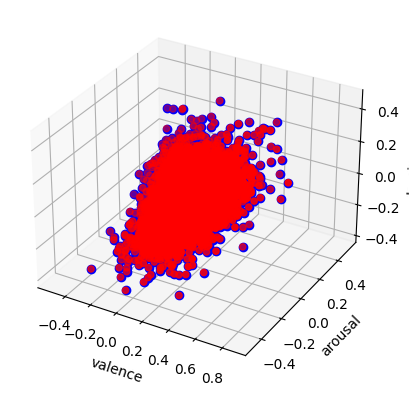

In [125]:
import matplotlib.pyplot as plt
import numpy as np

vectors = lyrics['affect majority score'].values

# Preprocess the vectors and convert to a valid NumPy array
processed_vectors = []
for vector in vectors:
    # Check if the vector is a valid three-dimensional array
    if isinstance(vector, np.ndarray) and vector.shape == (3,):
        processed_vectors.append(vector)

# Convert the processed vectors to a NumPy array
vectors_array = np.array(processed_vectors)

# Extract the x, y, and z components from the vectors array
valence = vectors_array[:, 0]
arousal = vectors_array[:, 1]
dominance = vectors_array[:, 2]

# Plot the vectors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(valence, arousal, dominance, 'bo')
ax.scatter(valence, arousal, dominance, color='r')

# Set labels for each axis
ax.set_xlabel('valence')
ax.set_ylabel('arousal')
ax.set_zlabel('dominance')

# Show the plot
plt.show()
